## EDA - Amazon Buy Box Algo Modelling

### A. Loading & Cleaning the Data
In this section, we import our libraries, read the raw data files (crawl2.txt, prime_sids.txt, susp_sids_all_with_amazon.txt), and do some basic preprocessing (like adding flags for prime/algo sellers and converting epoch timestamps to human-readable datetime).

In [ ]:
import pandas as pd 
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

# For formatting on plots (y-axis to percentages, log scaling, etc.)
from matplotlib.ticker import FuncFormatter

# scikit-learn imports for the classification step later
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Set a random seed for reproducibility
np.random.seed(42)


In [4]:
# 1) Load the main crawl data, rename columns
crawl2 = pd.read_table("crawl2.txt")
crawl2.columns = ["pid", "epoc", "sid", "price", "sid_rating", "sid_pos_fb", "sid_rating_cnt", "shipping", "page", "rank", "pid_rating", "pid_rating_cnt", "is_fba", "is_prime", "bbox_sid", "bbox_price"]


# 2) Load sets of prime seller IDs & algorithmic seller IDs
prime_sids = pd.read_table("prime_sids.txt", header=None, names=["prime_sids"])
algo_sellers = pd.read_table("susp_sids_all_with_amazon.txt", header=None, names=["algo_sids"])
crawl2["prime_seller"] = crawl2["sid"].isin(prime_sids["prime_sids"])
crawl2["algo_seller"] = crawl2["sid"].isin(algo_sellers["algo_sids"])

# 3) Display a small sample of the crawl2 data to verify loading 
display(crawl2.head())

,pid,epoc,sid,price,sid_rating,sid_pos_fb,sid_rating_cnt,shipping,page,rank,pid_rating,pid_rating_cnt,is_fba,is_prime,bbox_sid,bbox_price,prime_seller,algo_seller
0,0975277324,1439301853,A19HZ7QWHIRFQA,35.00,0.0,0,0,6.49,1,7,5.0,2321,yes,no,amazon,40.36,False,False
1,0975277324,1439301853,A1G1QJKXJJSAN2,44.06,5.0,98,3761,3.99,2,9,5.0,2321,no,no,amazon,40.36,False,False
2,0975277324,1439301853,A1H9LQ4XQ5IZ7D,39.99,5.0,97,1577,0.00,1,1,5.0,2321,yes,yes,amazon,40.36,True,False
3,0975277324,1439301853,A1OUQ84L1EU4IB,36.99,5.0,100,2,6.49,2,1,5.0,2321,no,no,amazon,40.36,False,False
4,0975277324,1439301853,A1PSEM5PTWSZBK,39.95,4.5,85,5308,6.10,2,4,5.0,2321,no,no,amazon,40.36,False,False


In [5]:
# 4) Count how many unique products (pid)
unique_pids = crawl2["pid"].unique().tolist()
print("Number of unique products:", len(unique_pids))

Number of unique products: 987


In [ ]:
# 5) Count how many sellers each product has, sort by descending count
pidsandcount = crawl2.groupby("pid").agg({"pid": "count"})
pidsandcount.columns = ["count"]
pidsandcount = pidsandcount.reset_index().sort_values(by="count", ascending=False)
print("Top 5 products by seller count:")
display(pidsandcount.head(5))

,pid,count
600,B009IH0BYQ,30140
255,B001EOV492,30110
159,B000NCOKZQ,30110
681,B00DJPK8PA,30110
63,B0002E1P08,30100


In [6]:
# 6) Create a copy of the data for further transformations
crawl_data = crawl2.copy()
# 7) Convert epoch to a pandas datetime
crawl_data["timestamp"] = pd.to_datetime(crawl_data["epoc"].astype(float), unit='s')

In [ ]:
# 8) Example of how to create a smaller sample if needed for testing or speed
sample_ids = np.random.choice(unique_pids, size=400, replace = False)
crawl_data_sample = crawl_data[crawl_data["pid"].isin(sample_ids)]

print("Sample data shape:", crawl_data_sample.shape)

### B.CDF of Interval Between Changes (Figure 2 Recreation)
Below, we calculate the time intervals between consecutive updates in the dataset. We track:
    1. Seller Price Update – how often an individual seller changes its own price.
    2. Buy Box Price Update – how often the winning Buy Box price changes.
    3. Buy Box Seller Update – how often the winning Buy Box seller changes.
After computing these intervals, we plot the cumulative distribution (CDF) of these inter-update times.

In [7]:
def calculate_inter_update_times(df):
    """
    Calculate the time intervals (in seconds) between:
    1) Seller price changes,
    2) Buy Box price changes,
    3) Buy Box seller changes.

    Returns:
        seller_price_update_times, bbox_price_update_times, bbox_seller_update_times
    """
     # Group by product
    product_groups = df.groupby('pid')

    # Lists to store the final time intervals
    seller_price_update_times = []
    bbox_price_update_times = []
    bbox_seller_update_times = []

    # We use defaultdict to store the last time we saw a particular event
    from collections import defaultdict

    
    for pid, group in product_groups:
        # Sort the group by time for proper chronological order
        group = group.sort_values('timestamp')
        
         # Track the last update time per seller's price
        last_price_update = defaultdict(lambda: None)
        # Track the last known Buy Box price (and time)
        last_bbox_price = None
        # Track the last known Buy Box seller (and time)
        last_bbox_seller = None
        
        for _, row in group.iterrows():
            timestamp = row['timestamp']
            seller_id = row['sid']
            bbox_price = row['bbox_price']
            bbox_seller = row['bbox_sid']
            
             # 1) Seller Price Update
            if last_price_update[seller_id] is not None:
                time_diff = (timestamp - last_price_update[seller_id]).total_seconds()
                seller_price_update_times.append(time_diff)
            # update last price update time for this seller
            last_price_update[seller_id] = timestamp
            
            # 2) Buy Box Price Update
            if last_bbox_price is not None and bbox_price != last_bbox_price:
                time_diff = (timestamp - last_bbox_price[1]).total_seconds()
                bbox_price_update_times.append(time_diff)
                last_bbox_price = (bbox_price, timestamp)
            elif last_bbox_price is None:
                last_bbox_price = (bbox_price, timestamp)
            
            # 3) Buy Box Seller Update
            if last_bbox_seller is not None and bbox_seller != last_bbox_seller[0]:
                time_diff = (timestamp - last_bbox_seller[1]).total_seconds()
                bbox_seller_update_times.append(time_diff)
                last_bbox_seller = (bbox_seller, timestamp)
            elif last_bbox_seller is None:
                last_bbox_seller = (bbox_seller, timestamp)
            
            
    
    return seller_price_update_times, bbox_price_update_times, bbox_seller_update_times

In [ ]:
def plot_cumulative_distribution(seller_times, bbox_price_times, bbox_seller_times, save_path=None):

    """
    Plot the CDF of the time intervals (converted to minutes, log-scaled on the x-axis).
    We display three lines:
    1) Seller Price Updates
    2) Buy Box Price Updates
    3) Buy Box Seller Updates
    """
    # Sort the time arrays for plotting a proper CDF
    seller_times = sorted(seller_times)
    bbox_price_times = sorted(bbox_price_times)
    bbox_seller_times = sorted(bbox_seller_times)
    
    # Compute y-values for the CDF: y = rank / total
    seller_y = np.arange(1, len(seller_times) + 1) / len(seller_times)
    bbox_price_y = np.arange(1, len(bbox_price_times) + 1) / len(bbox_price_times)
    bbox_seller_y = np.arange(1, len(bbox_seller_times) + 1) / len(bbox_seller_times)
    
    # Convert seconds -> minutes
    seller_times_min = [t / 60 for t in seller_times]
    bbox_price_times_min = [t / 60 for t in bbox_price_times]
    bbox_seller_times_min = [t / 60 for t in bbox_seller_times]
    
    # Initialize plot
    fig, ax = plt.subplots()
    
    # Plot each CDF line
    ax.plot(seller_times_min, seller_y, label='Seller Price Updates')
    ax.plot(bbox_price_times_min, bbox_price_y, label='Buy Box Price Updates')
    ax.plot(bbox_seller_times_min, bbox_seller_y, label='Buy Box Seller Updates')
    
    # X-axis in log scale
    ax.set_xscale('log')
    
    # Format y-axis as percentage
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
    
    # Axis labels & title
    ax.set_xlabel('Inter-Update Time (minutes, log scale)')
    ax.set_ylabel('Cumulative Percentage')
    ax.set_title('Figure 2: Cumulative Distribution of Inter-Update Times')
    ax.legend(loc='lower right')
    ax.grid(True, alpha=0.3)

    # Customize x-axis ticks (log scale means we specify approximate breakpoints)
    time_ticks = [1/60, 1/6, 1, 10, 60, 6*60, 24*60]
    time_labels = ['1s', '10s', '1m', '10m', '1h', '6h', '24h']
    ax.set_xticks(time_ticks)
    ax.set_xticklabels(time_labels)
    
    # Show or save the figure
    plt.show()
    if save_path:
        fig.savefig(save_path, dpi=300)

seller_times, bbox_price_times, bbox_seller_times = calculate_inter_update_times(crawl_data)


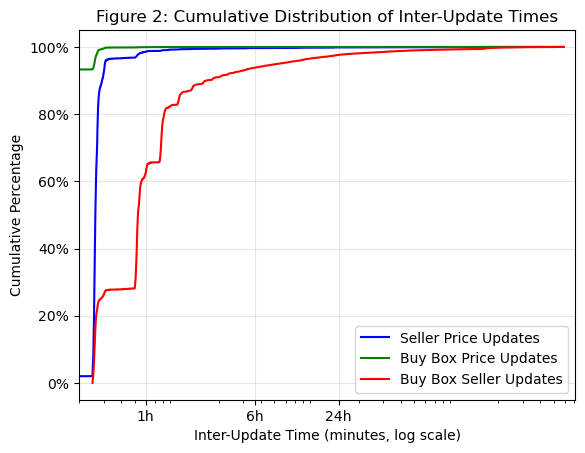

In [99]:
plot_cumulative_distribution(seller_times, bbox_price_times, bbox_seller_times)

### C. Probability of Winning Buy Box by Rank (Figure 9 Recreation)

This section computes each seller’s probability of having the Buy Box, giventheir listing rank. Then, we plot that probability (a to see how it changes with rank.

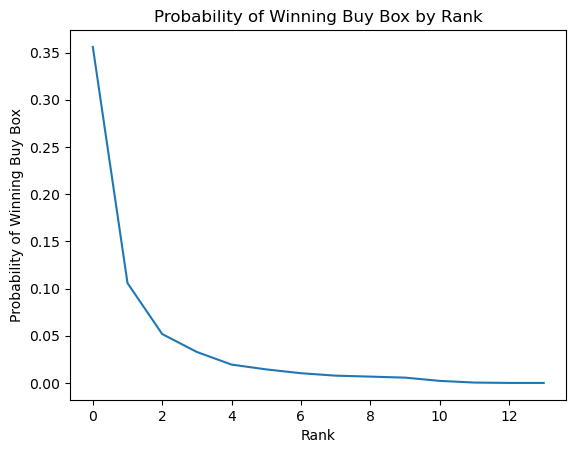

In [9]:
# 1) Create a "wonbbox" column: True if 'sid' is the same as the 'bbox_sid'
crawl_data["wonbbox"] = crawl_data["bbox_sid"] == crawl_data["sid"]

# 2) Group by rank, compute the mean of "wonbbox"
crawl_data_winrate_by_rank = crawl_data.groupby("rank").agg({"wonbbox" : "mean"})

# 3) Plot the results
plt.figure()
plt.plot(crawl_data_winrate_by_rank.index, crawl_data_winrate_by_rank.values, linestyle='-')
plt.xlabel('Rank')
plt.ylabel('Probability of Winning Buy Box')
plt.title('Probability of Winning Buy Box by Rank')
plt.show()

### C. Recreation of RF Classifier - Table 1

In [ ]:
# 1) Copy data for the RF
crawl_rf = crawl_data.copy()

# 2) Feature engineering
crawl_rf["price_lowest"] = crawl_data.groupby("pid")["price"].transform("min")
crawl_rf["price_difference_to_lowest"] = crawl_rf["price"] - crawl_rf["price_lowest"]
crawl_rf["price_ratio_to_lowest"] = crawl_rf["price"]/crawl_rf["price_lowest"]
crawl_rf["positive_feedback"] = crawl_rf["sid_pos_fb"]
crawl_rf["is_amazon_seller"] = crawl_rf["sid"] == "amazon"
crawl_rf["feedback_count"] = crawl_rf["sid_rating_cnt"]
crawl_rf["average_rating"] = crawl_rf["sid_rating"]
crawl_rf["is_product_fba"] = crawl_rf["is_fba"] == "yes"

# 3) Example: sample a subset of products for faster training
rf_sample_ids = np.random.choice(unique_pids, size=200, replace = False)
crawl_rf_sample = crawl_rf[crawl_rf["pid"].isin(rf_sample_ids)]

# 4) Prepare X, y
X = crawl_rf_sample[["price_difference_to_lowest","price_ratio_to_lowest", "positive_feedback","is_amazon_seller","feedback_count", "average_rating","is_product_fba"]]
y = crawl_rf_sample["wonbbox"]

# 5) Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# 6) Train RandomForest
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)
# 7) Predictions & evaluation
y_pred = rf_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.9858
              precision    recall  f1-score   support

       False       0.99      0.99      0.99    761349
        True       0.92      0.88      0.90     58505

    accuracy                           0.99    819854
   macro avg       0.95      0.94      0.95    819854
weighted avg       0.99      0.99      0.99    819854



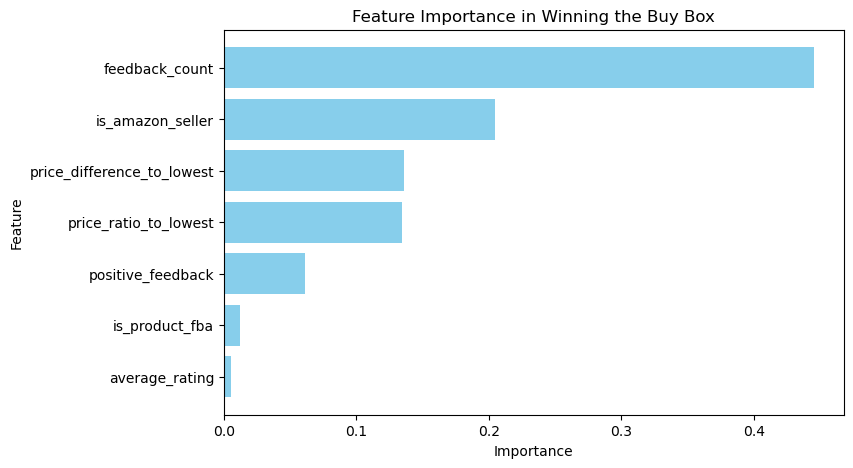

In [ ]:
# 8) Plot feature importance
feature_importances = rf_classifier.feature_importances_
importance_df = pd.DataFrame({'Feature': ["price_difference_to_lowest","price_ratio_to_lowest", "positive_feedback","is_amazon_seller","feedback_count", "average_rating","is_product_fba"], 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(8, 5))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance in Winning the Buy Box")
plt.gca().invert_yaxis()
plt.show()

### E. Comparing Algorithmic vs Non-Algorithmic Sellers
We compare the average price of “algorithmic” sellers against “non-algorithmic” sellers, focusing on products where both seller types are present.

C:\Users\Meg Balakrishnan\AppData\Local\Temp\ipykernel_16616\1468075530.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  common_products["pct_diff"] = (


Average percentage difference (algorithmic vs non-algorithmic): -6.92%


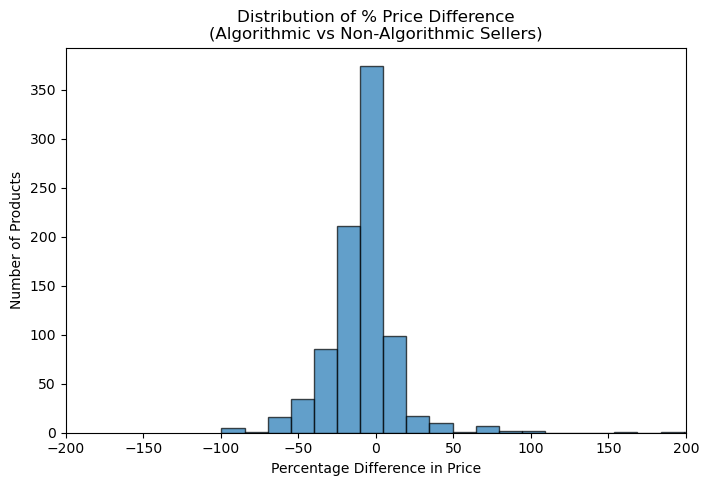

In [10]:
np.random.seed(42)

# 1) Group by (product ID, algo_seller flag), compute average price
grouped_prices = crawl_data.groupby(["pid", "algo_seller"])["price"].mean().reset_index()

# 2) Pivot so that each product has two columns: "non_algo_avg_price" and "algo_avg_price"
price_pivot = grouped_prices.pivot(index="pid", columns="algo_seller", values="price")

# Rename pivot columns for clarity
price_pivot.columns = ["non_algo_avg_price", "algo_avg_price"]

# 3) Filter out products that do not have both types of sellers
common_products = price_pivot.dropna()

# 4) Calculate % difference in price
common_products["pct_diff"] = (
    (common_products["algo_avg_price"] - common_products["non_algo_avg_price"]) 
    / common_products["non_algo_avg_price"] * 100
)

# 5) Overall average difference
avg_pct_diff = common_products["pct_diff"].mean()
print(f"Average percentage difference (algorithmic vs non-algorithmic): {avg_pct_diff:.2f}%")

# 6) Plot a histogram of the percentage differences
plt.figure(figsize=(8, 5))
plt.hist(common_products["pct_diff"], bins=60, edgecolor="black", alpha=0.7)
plt.xlim(-200, 200)
plt.xlabel("Percentage Difference in Price")
plt.ylabel("Number of Products")
plt.title("Distribution of % Price Difference\n(Algorithmic vs Non-Algorithmic Sellers)")
plt.show()

### F. Visualizing Individual Product Price Timelines
We define a helper function that, for a random product (PID), plots each seller’s price over time. Sellers flagged as “algorithmic” will be in one color, and non-algo sellers in another. This helps visualize patterns such as price matching, reactive behavior, etc.


In [11]:
# 1) Filter the main dataset to only keep products that:
#    a) Have at most 5 unique sellers
#    b) Contain at least one algo-seller and one non-algo seller

filtered_crawl_data = crawl_data.groupby("pid").filter(lambda group: group["sid"].nunique() <= 5)
filtered_crawl_data = filtered_crawl_data.groupby("pid").filter(lambda group: group["algo_seller"].any() and (~group["algo_seller"]).any())


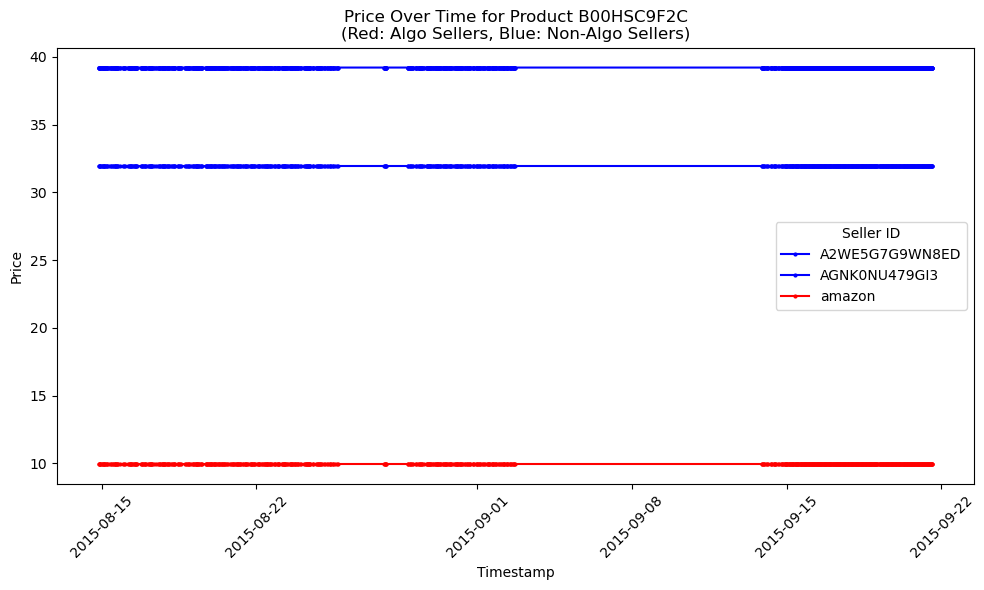

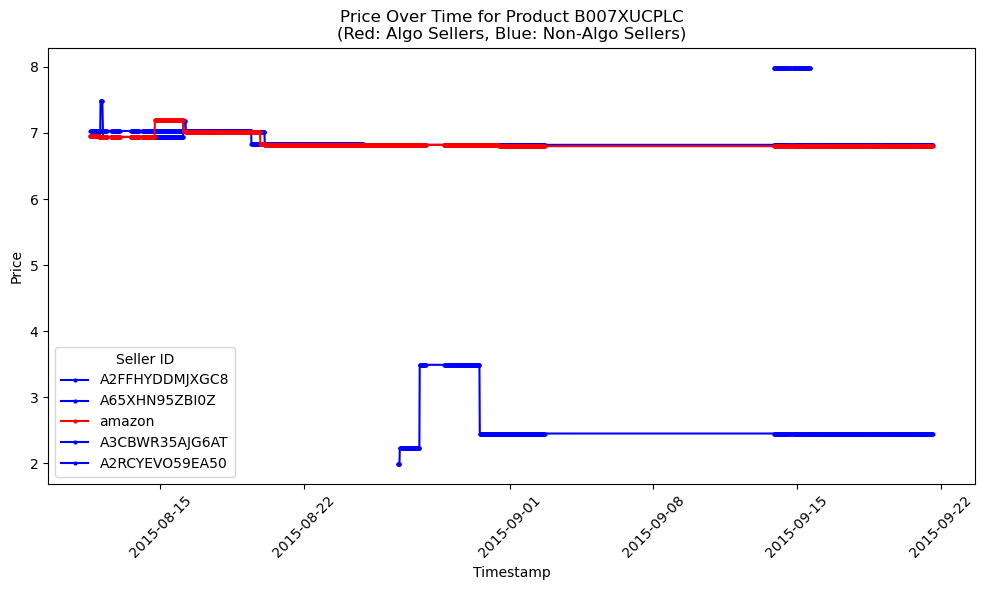

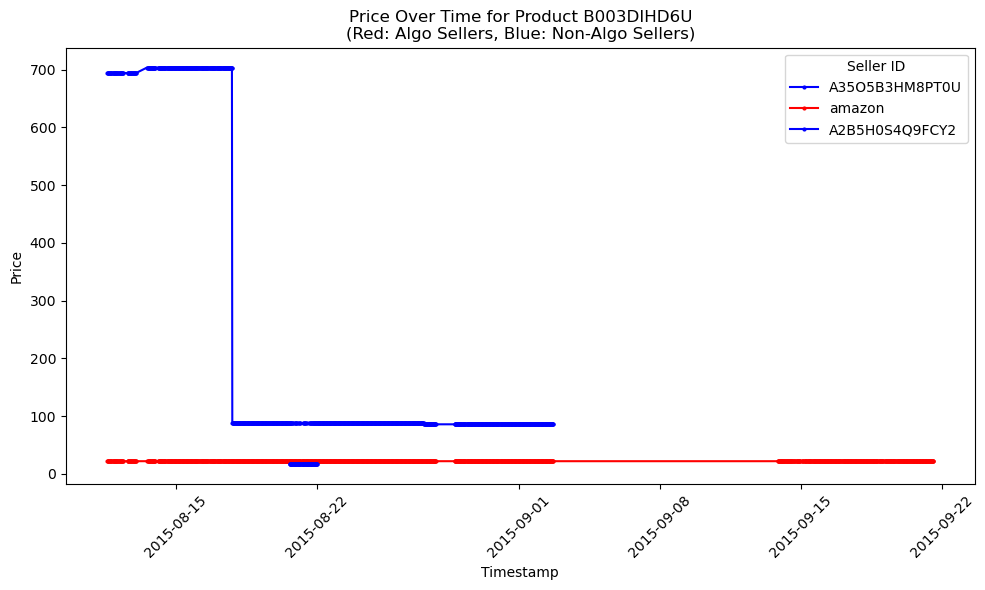

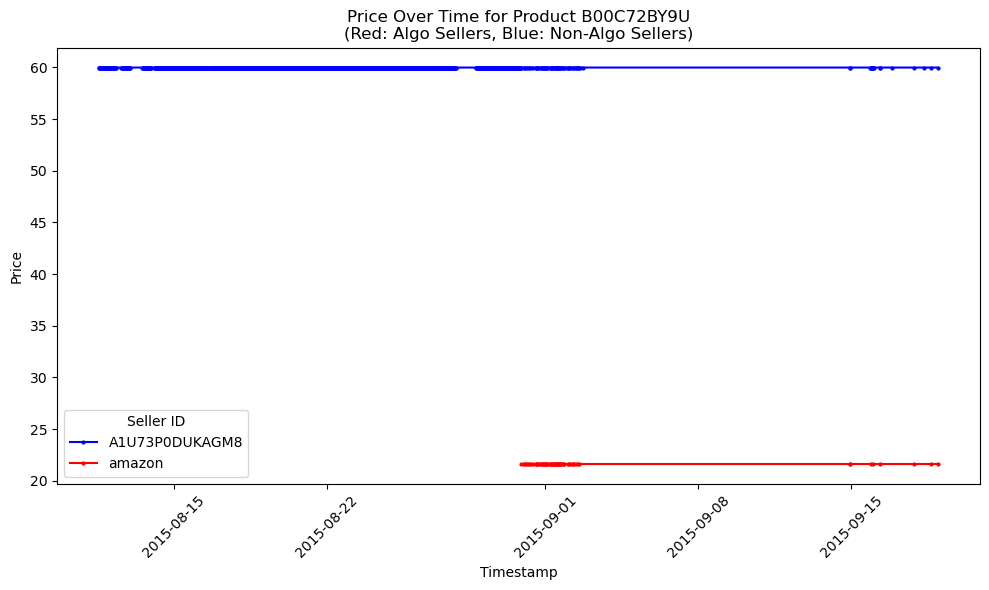

In [12]:
# 2) Define a function that picks a random product PID and plots all sellers' price time series
def product_price(filtered_crawl_data=filtered_crawl_data):
    """
    Plots the price over time for a random product from 'df'.
    'df' is expected to have the columns: 
        - 'pid', 'sid', 'timestamp', 'price', 'algo_seller'
    """
    # Randomly choose one product from the filtered set
    random_pid = np.random.choice(filtered_crawl_data["pid"].unique())

    # Extract that product's data and convert timestamps
    product_data = filtered_crawl_data[filtered_crawl_data["pid"] == random_pid].copy()
    product_data["timestamp"] = pd.to_datetime(product_data["timestamp"])

     # Gather all unique sellers for this product
    sellers = product_data["sid"].unique()

     # Plot
    plt.figure(figsize=(10, 6))
    for sid in sellers:
        seller_data = product_data[product_data["sid"] == sid].sort_values("timestamp")

        # If 'algo_seller' is True for this seller, color it differently
        seller_color = "red" if seller_data["algo_seller"].iloc[0] else "blue"
        plt.plot(seller_data["timestamp"], seller_data["price"], 
                label=sid, color=seller_color, marker="o", markersize=2, linestyle="-")

    plt.xlabel("Timestamp")
    plt.ylabel("Price")
    plt.title(f"Price Over Time for Product {random_pid}\n(Red: Algo Sellers, Blue: Non-Algo Sellers)")
    plt.xticks(rotation=45)
    plt.legend(title="Seller ID")
    plt.tight_layout()
    plt.show()
# 3) Call the function multiple times to see different products
product_price()
product_price()
product_price()
product_price()

#### Excluding Amazon as a Seller

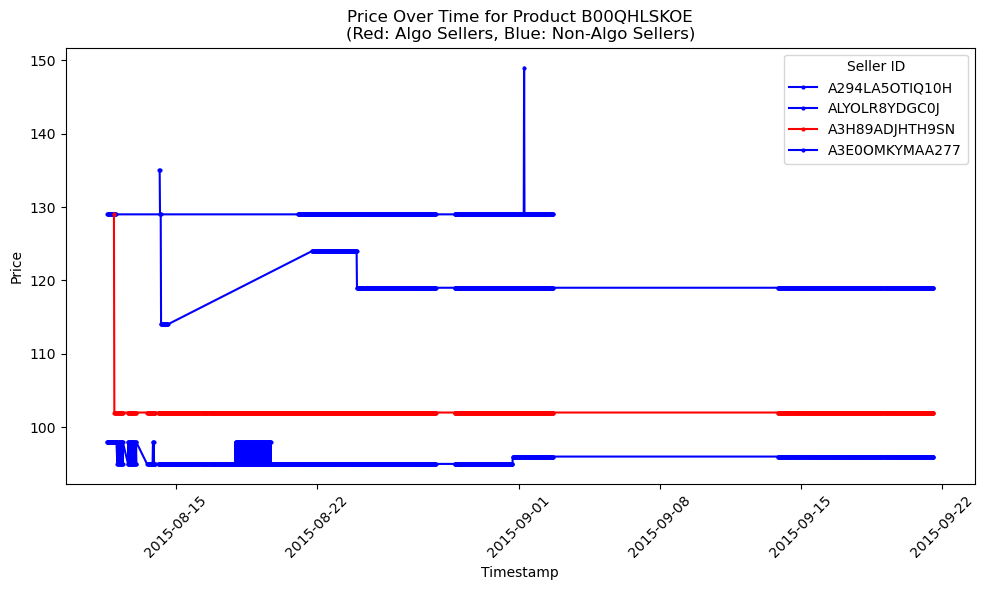

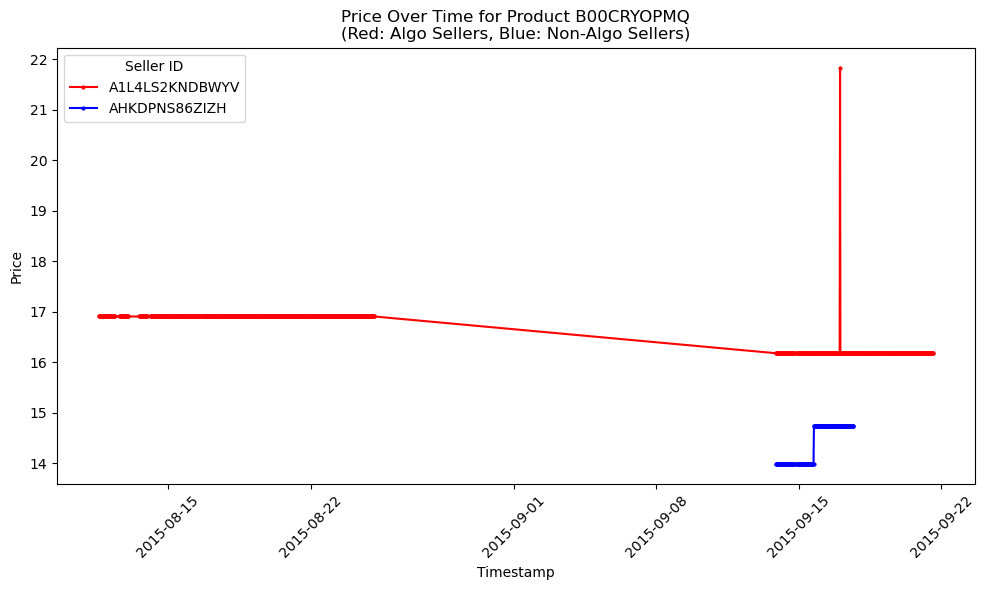

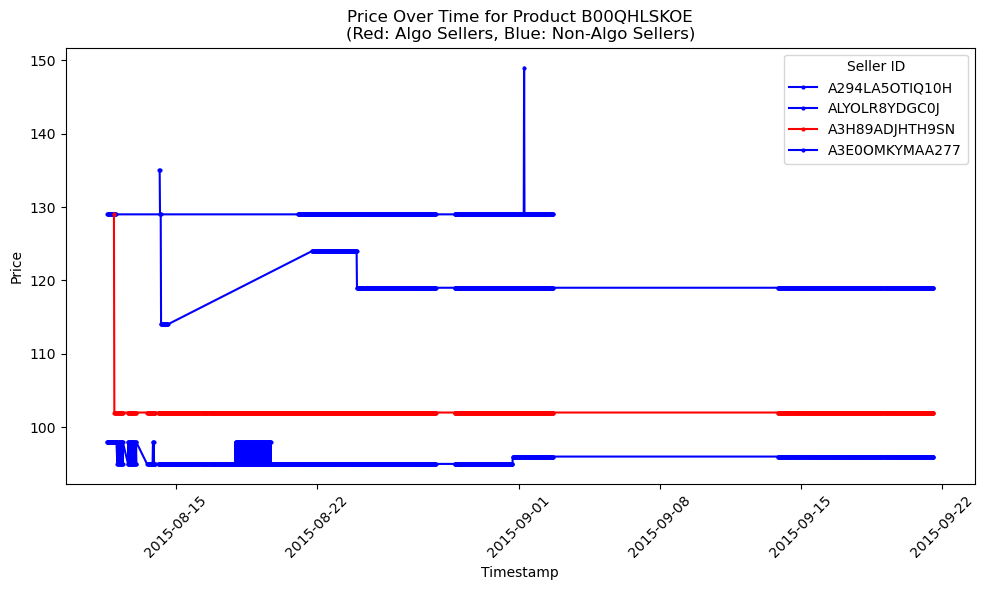

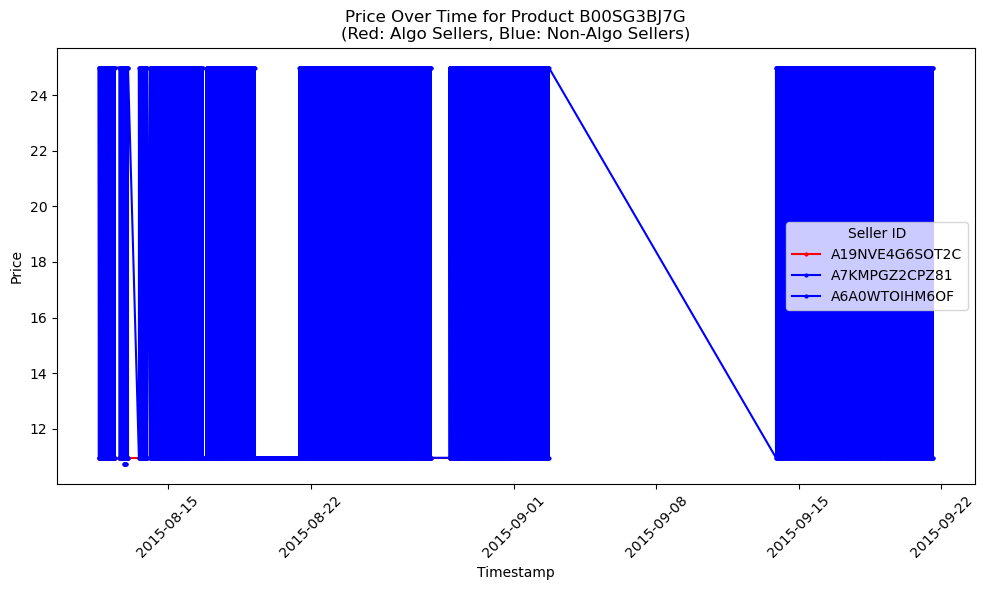

In [13]:
# 1) Filter out Amazon from the dataset
no_amazon_filtered_crawl_data = filtered_crawl_data[filtered_crawl_data["sid"] != "amazon"]

# 2) Make sure the product set still meets the conditions:
#    - At most 5 sellers
#    - Contains at least one algo seller and one non-algo seller
no_amazon_filtered_crawl_data = no_amazon_filtered_crawl_data.groupby("pid").filter(lambda group: group["sid"].nunique() <= 5)
no_amazon_filtered_crawl_data = no_amazon_filtered_crawl_data.groupby("pid").filter(lambda group: group["algo_seller"].any() and (~group["algo_seller"]).any())

# 3) Test the same plotting function on the "no Amazon" filtered dataset
product_price(no_amazon_filtered_crawl_data)
product_price(no_amazon_filtered_crawl_data)
product_price(no_amazon_filtered_crawl_data)
product_price(no_amazon_filtered_crawl_data)
